In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
den8_gt <-
    future_map(1:8, function(x) {
        read_genotypes("den8", "full", mindp = x, var_only = TRUE) %>%
            select(den8) %>%
            setNames(paste0("den8", "_dp", x))
    }) %>% bind_cols

In [4]:
den8_gt <- read_genotypes("den8", "full", mindp = 1, var_only = TRUE) %>%
    select(chrom, pos, REF, ALT, a00, S_Dinka_1, S_French_1) %>%
    bind_cols(den8_gt)

In [5]:
head(den8_gt)

chrom,pos,REF,ALT,a00,S_Dinka_1,S_French_1,den8_dp1,den8_dp2,den8_dp3,den8_dp4,den8_dp5,den8_dp6,den8_dp7,den8_dp8
Y,2649855,G,C,0,0,0,0,NA,NA,NA,NA,NA,NA,NA
Y,2649905,C,T,0,0,0,0,0,0,0,NA,NA,NA,NA
Y,2649955,G,A,0,0,0,1,NA,NA,NA,NA,NA,NA,NA
Y,2649988,T,C,0,0,0,NA,NA,NA,NA,NA,NA,NA,NA
Y,2650020,C,T,NA,0,0,0,0,0,0,0,0,NA,NA
Y,2650264,G,A,0,0,0,1,NA,NA,NA,NA,NA,NA,NA


In [14]:
den4_gt <-
    future_map(1:8, function(x) {
        read_genotypes("den4", "full", mindp = x, var_only = TRUE) %>%
            select(den4) %>%
            setNames(paste0("den4", "_dp", x))
    }) %>% bind_cols

In [15]:
den4_gt <- read_genotypes("den4", "full", mindp = 1, var_only = TRUE) %>%
    select(chrom, pos, REF, ALT, a00, S_Dinka_1, S_French_1) %>%
    bind_cols(den4_gt)

In [16]:
head(den4_gt)

chrom,pos,REF,ALT,a00,S_Dinka_1,S_French_1,den4_dp1,den4_dp2,den4_dp3,den4_dp4,den4_dp5,den4_dp6,den4_dp7,den4_dp8
Y,2649847,C,T,0,0,0,1,NA,NA,NA,NA,NA,NA,NA
Y,2649855,G,C,0,0,0,0,NA,NA,NA,NA,NA,NA,NA
Y,2649905,C,T,0,0,0,NA,NA,NA,NA,NA,NA,NA,NA
Y,2649988,T,C,0,0,0,NA,NA,NA,NA,NA,NA,NA,NA
Y,2650020,C,T,NA,0,0,0,0,0,0,0,NA,NA,NA
Y,2650195,G,A,0,0,0,1,NA,NA,NA,NA,NA,NA,NA


In [6]:
neand_gt <-
    future_map(1:5, function(x) {
        read_genotypes("neand", "full", mindp = x, var_only = TRUE ) %>%
            select(neand) %>%
            setNames(paste0("neand", "_dp", x))
    }) %>%
        bind_cols

In [7]:
neand_gt <- read_genotypes("neand", "full", mindp = 1, var_only = TRUE) %>%
    select(chrom, pos, REF, ALT, a00, S_Dinka_1, S_French_1) %>%
    bind_cols(neand_gt)

In [8]:
head(neand_gt)

chrom,pos,REF,ALT,a00,S_Dinka_1,S_French_1,neand_dp1,neand_dp2,neand_dp3,neand_dp4,neand_dp5
Y,2649855,G,C,0,0,0,0,0,0,0,0
Y,2649905,C,T,0,0,0,0,0,0,0,0
Y,2649988,T,C,0,0,0,0,0,0,0,0
Y,2650020,C,T,NA,0,0,0,0,0,0,0
Y,2650291,G,T,0,0,0,0,0,0,0,0
Y,2650321,G,A,0,0,NA,0,0,0,0,0


In [9]:
den8_props <- snp_props(den8_gt, normalize = "T-C")

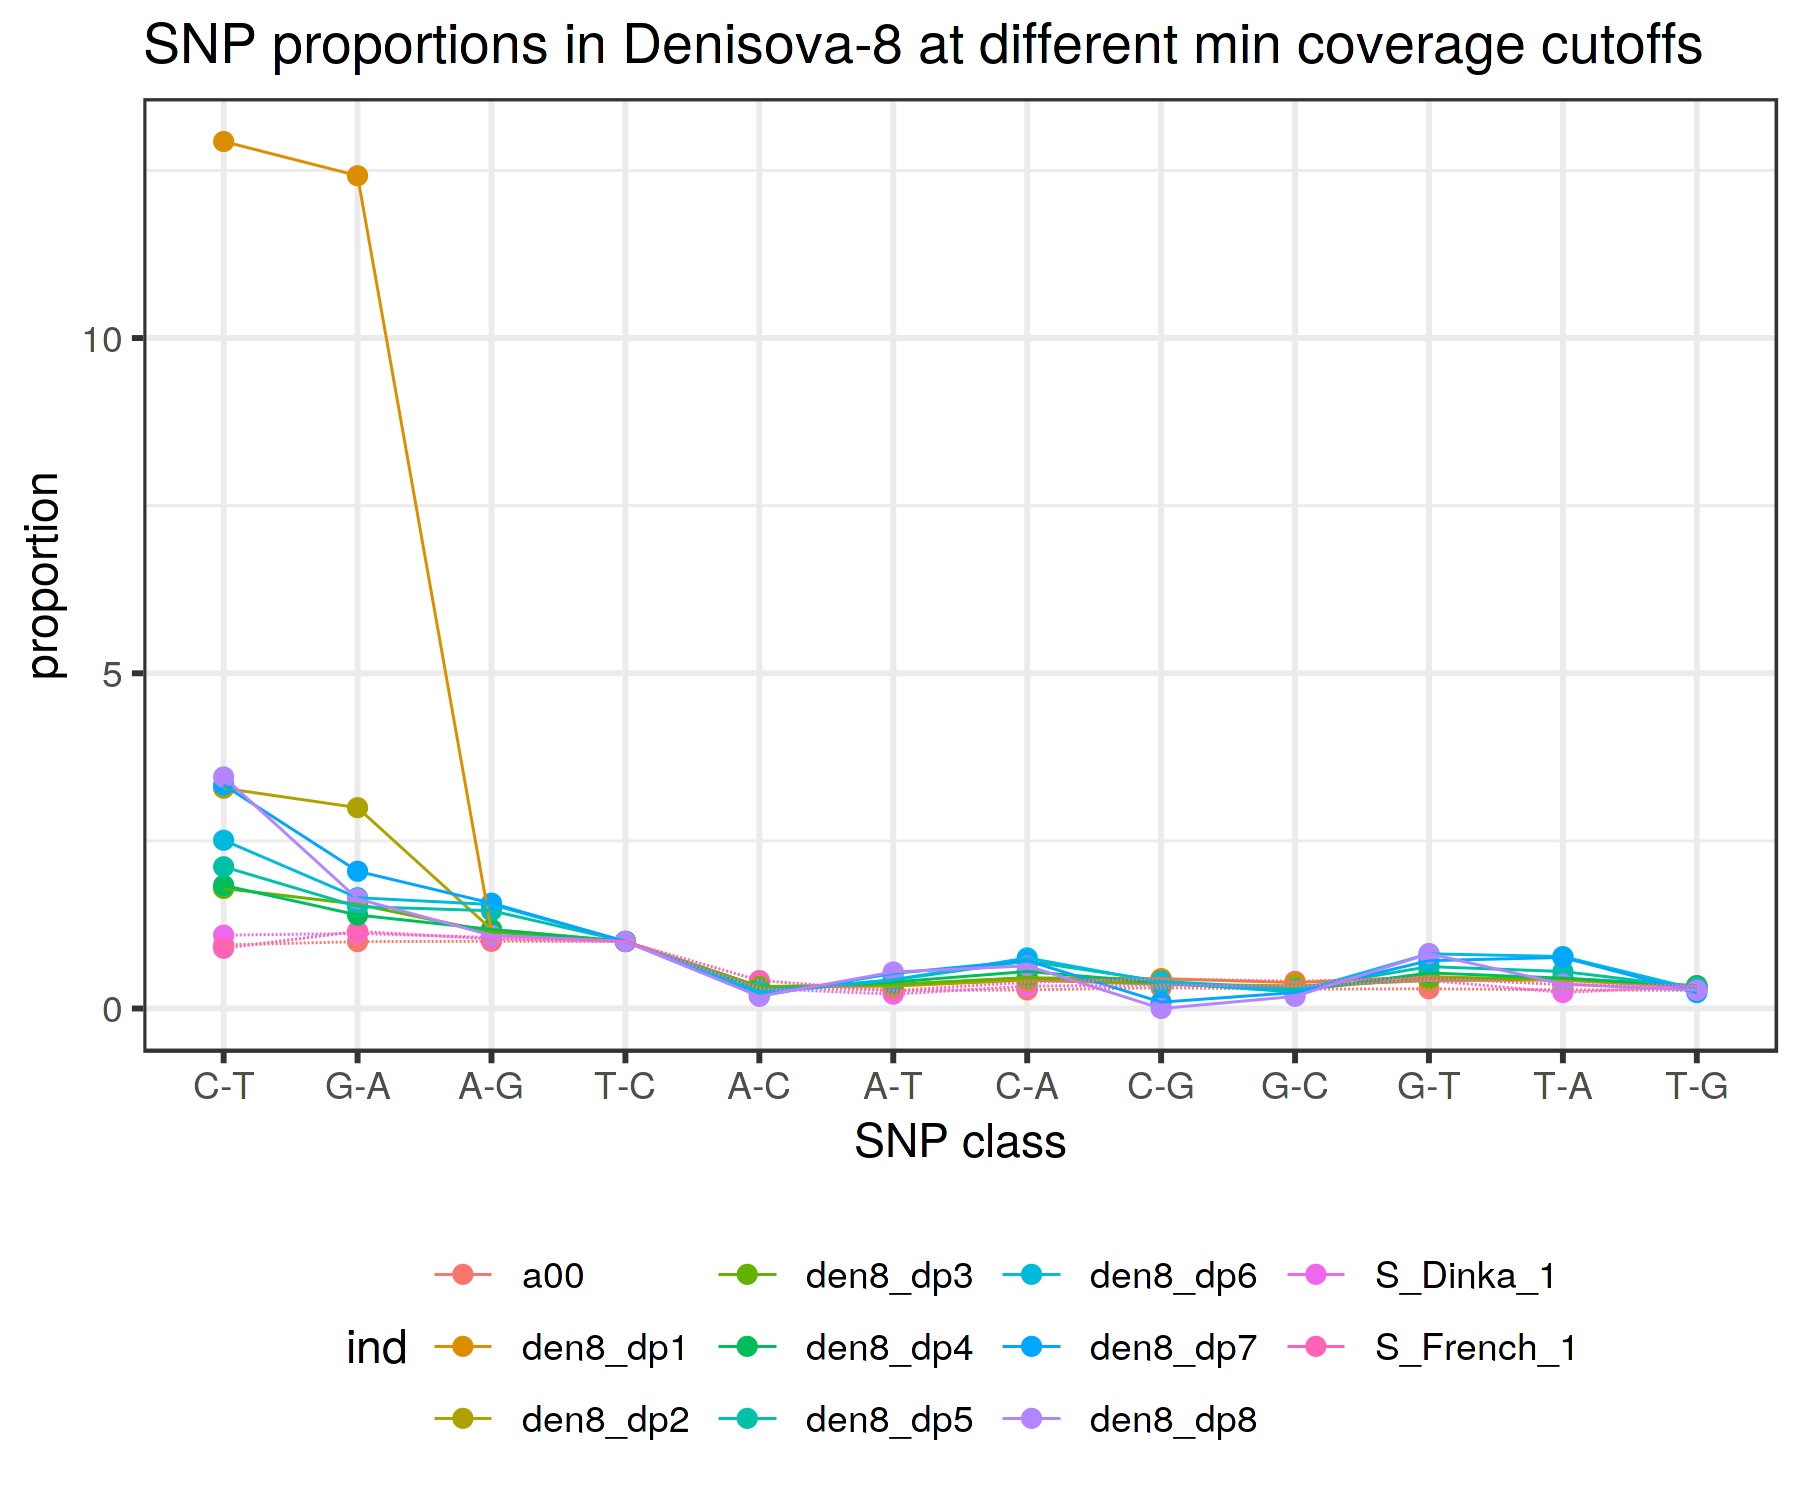

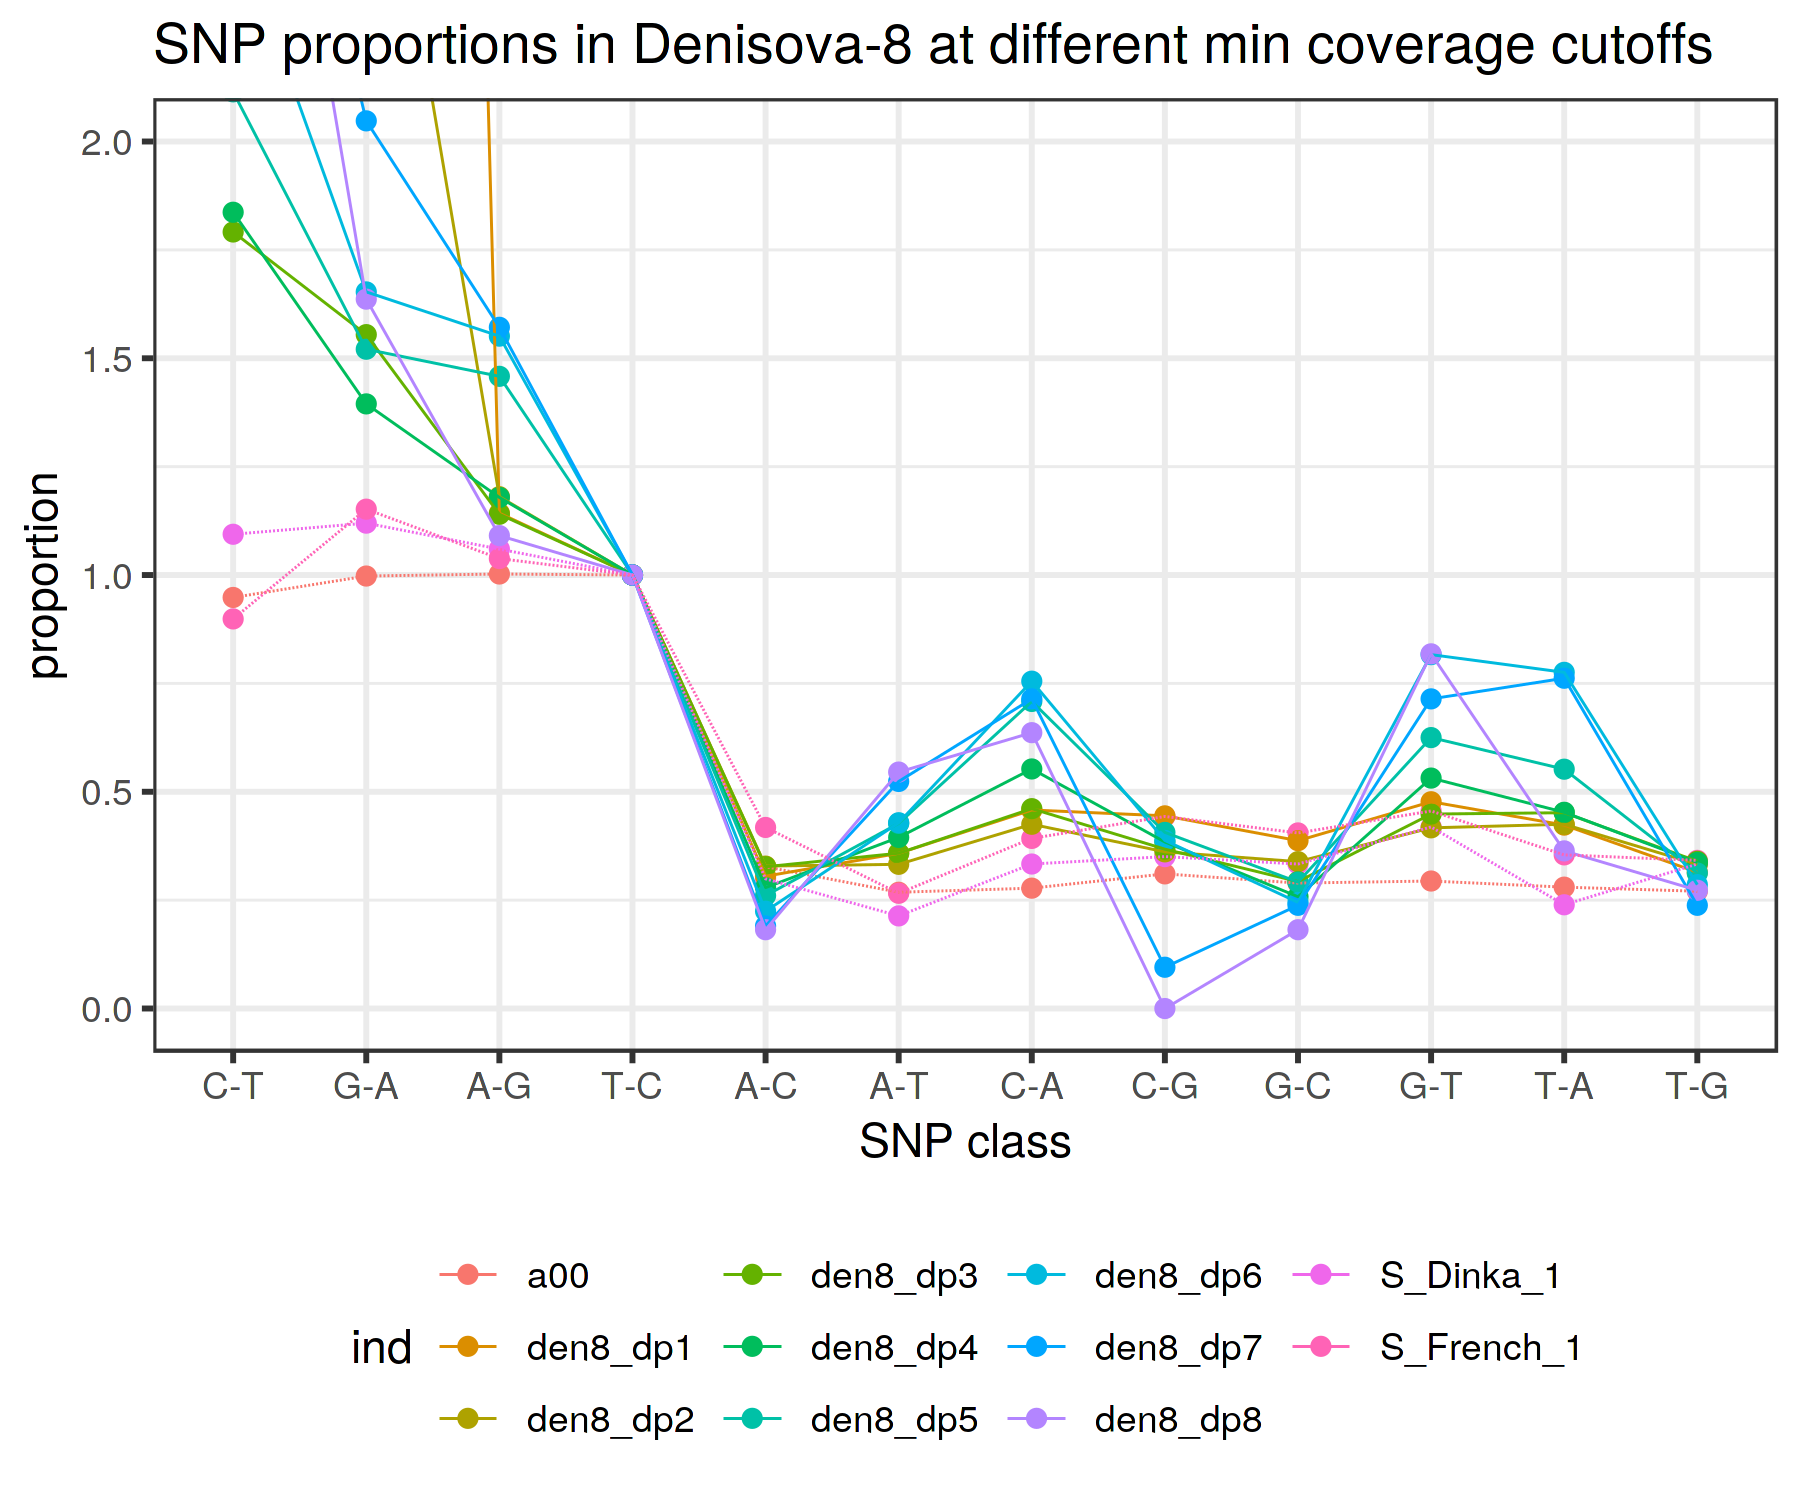

In [10]:
set_dim(6, 5)

den8_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different min coverage cutoffs")

den8_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different min coverage cutoffs")

In [17]:
den4_props <- snp_props(den4_gt, normalize = "T-C")

Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_path).”Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_path).”

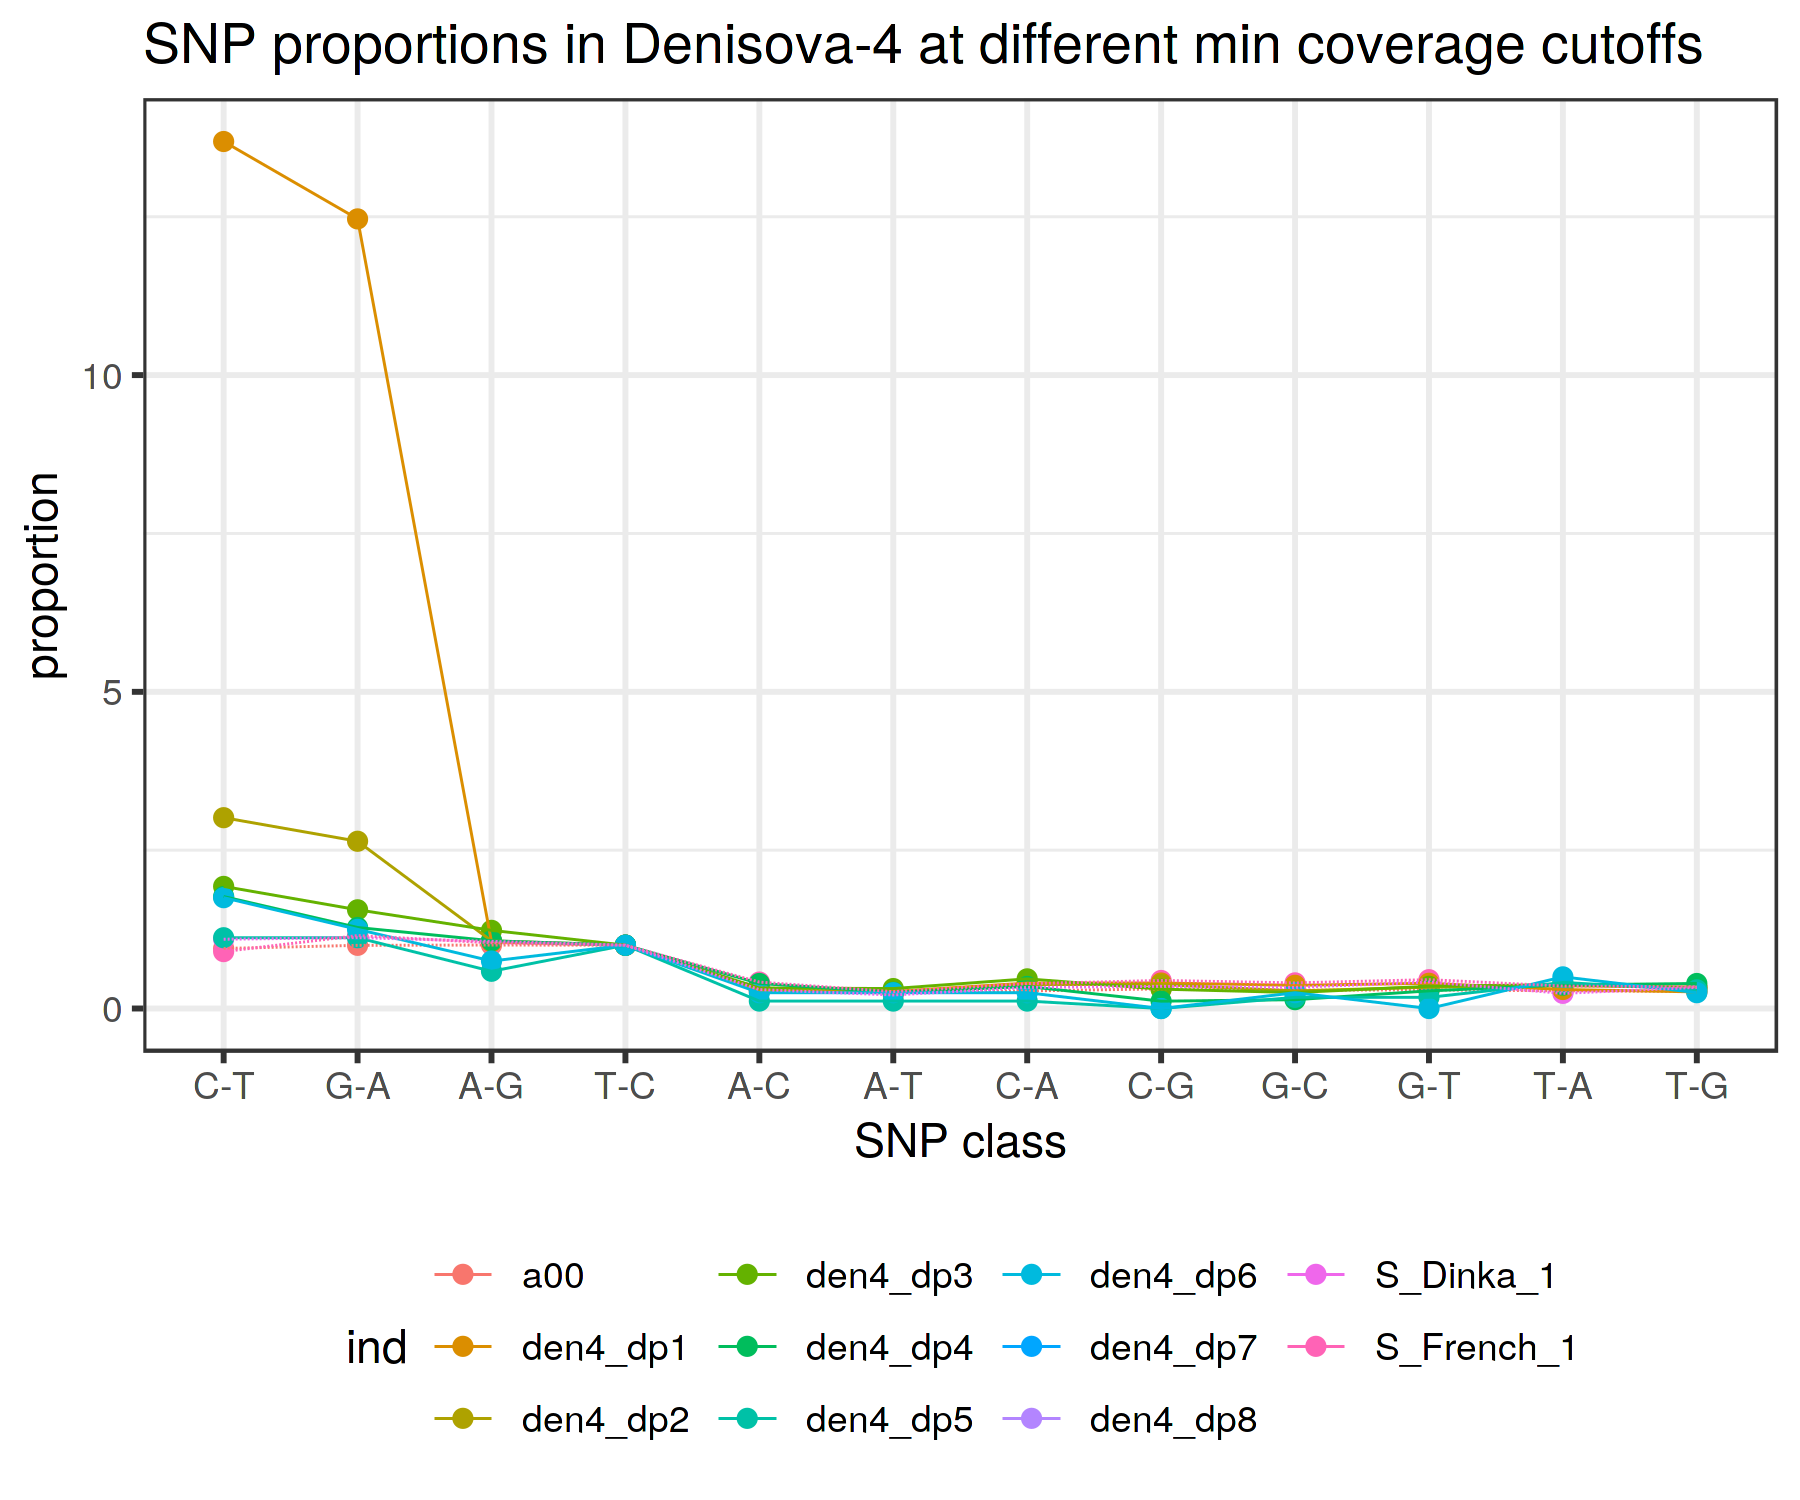

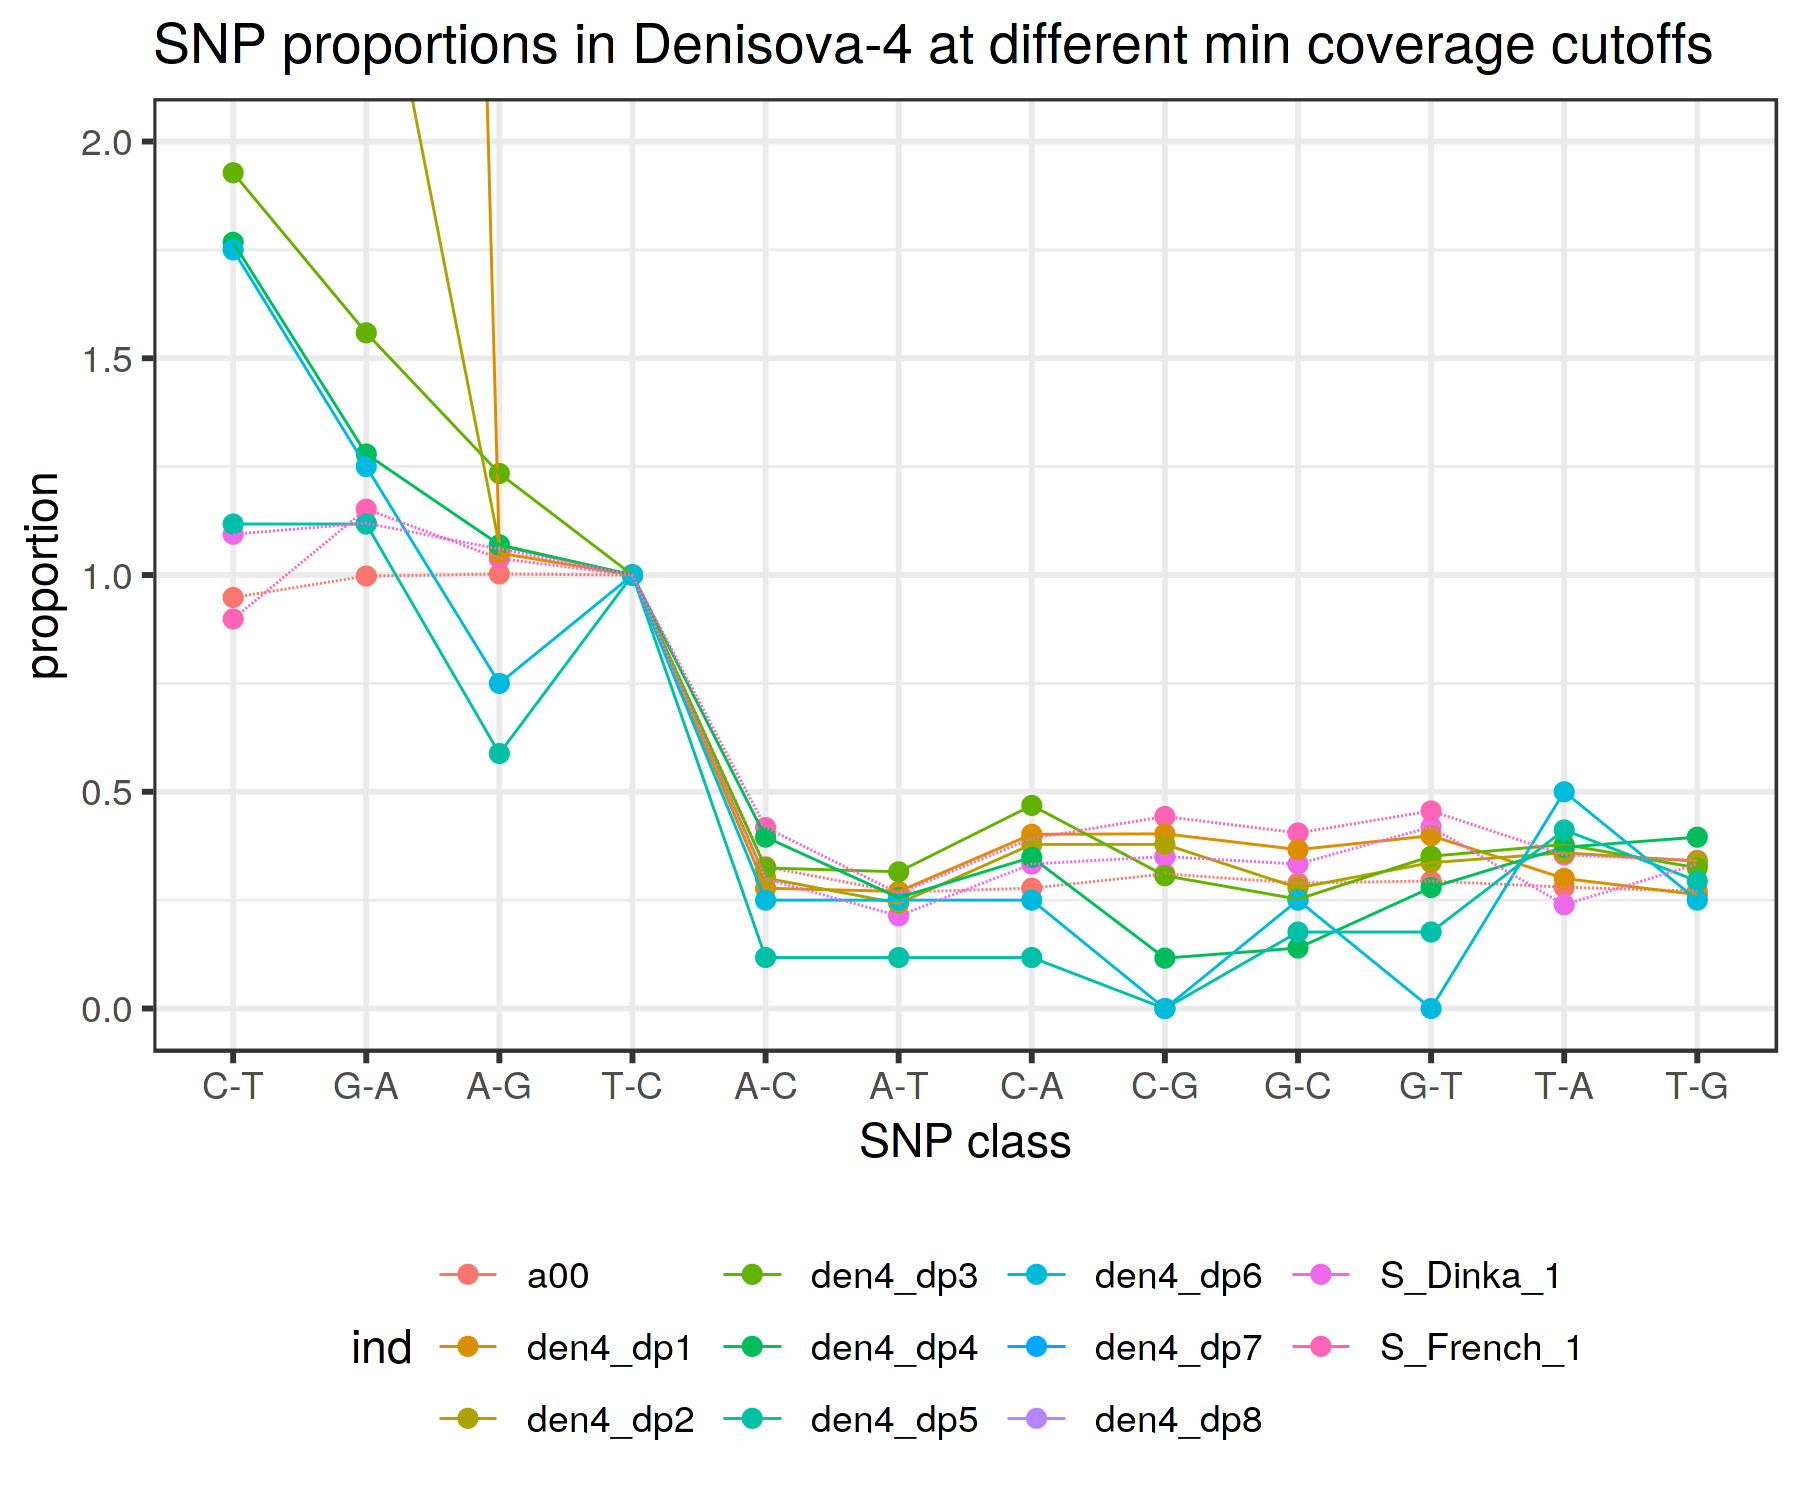

In [19]:
set_dim(6, 5)

den4_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den4")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-4 at different min coverage cutoffs")

den4_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den4")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-4 at different min coverage cutoffs")

In [11]:
neand_props <- snp_props(neand_gt, normalize = "T-C")

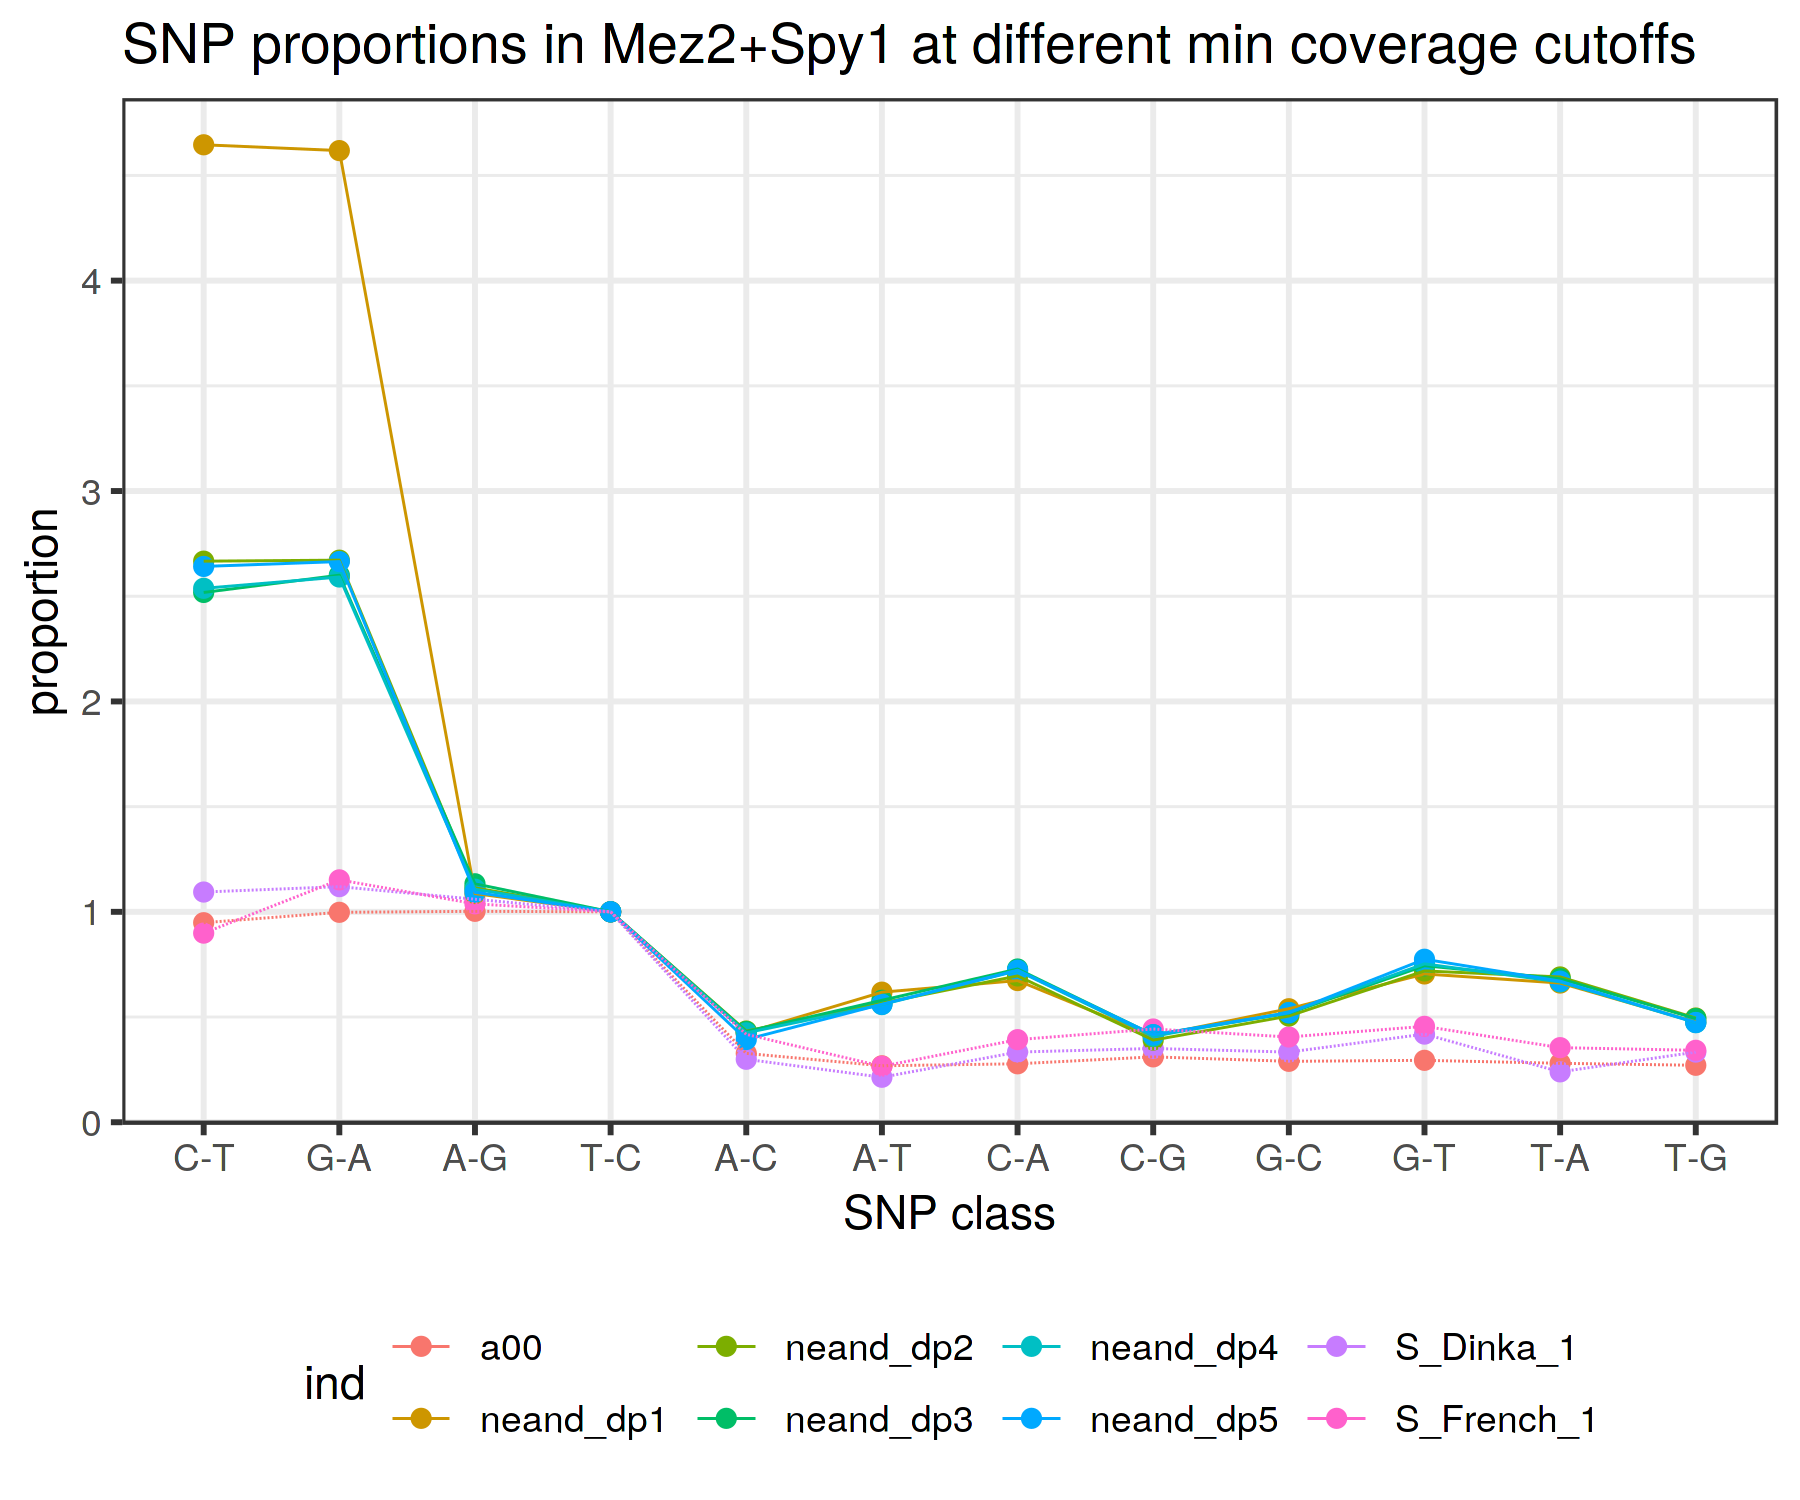

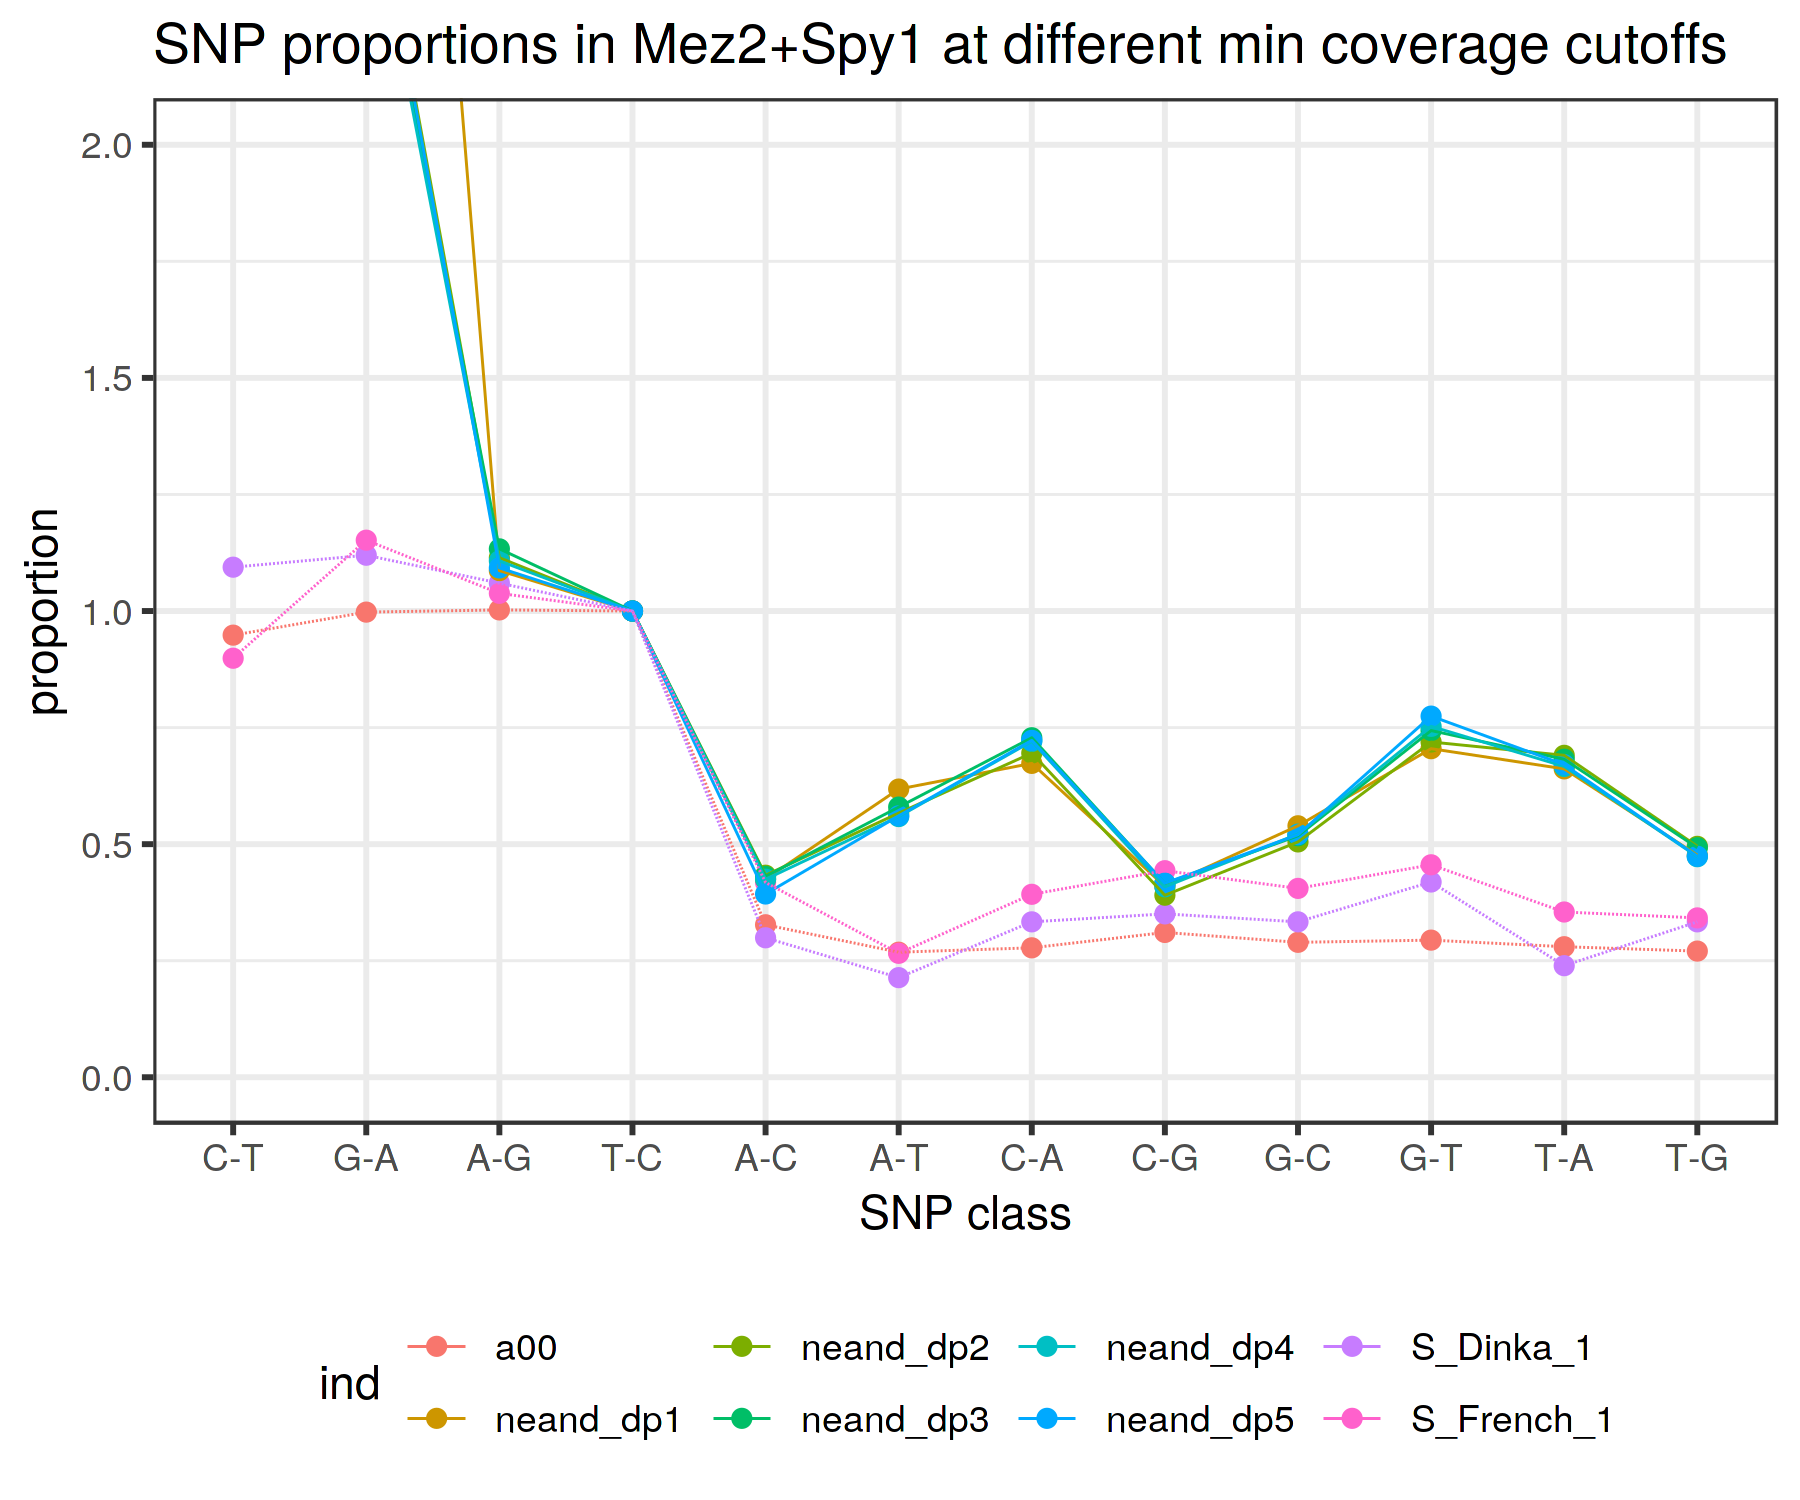

In [13]:
set_dim(6, 5)

neand_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez2+Spy1 at different min coverage cutoffs")

neand_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez2+Spy1 at different min coverage cutoffs")